In [67]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import json

In [68]:
#data import
game_data = pd.read_csv('data/clean_data.csv')

<AxesSubplot:>

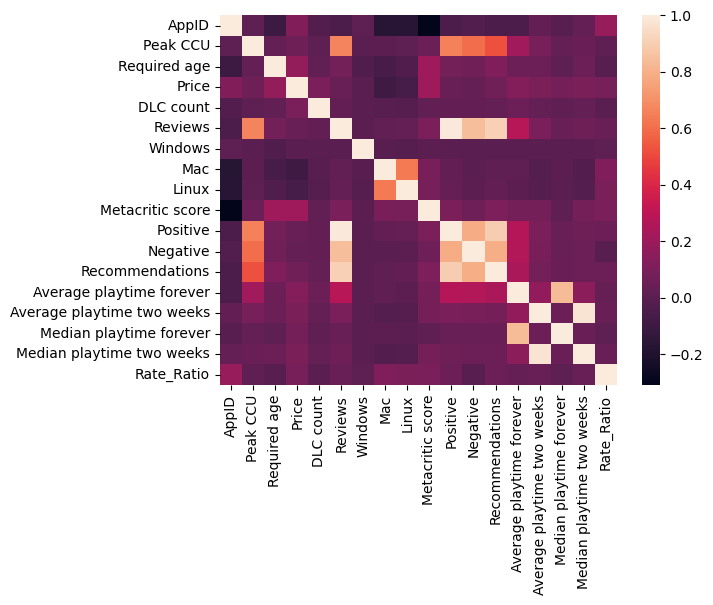

In [69]:
sb.heatmap(data=game_data.corr())

In [70]:
corr_table = game_data.corr()["Price"]
corr_table.head()

AppID           0.115436
Peak CCU        0.058408
Required age    0.171963
Price           1.000000
DLC count       0.094627
Name: Price, dtype: float64

In [71]:
for index, row in corr_table.items():
    print(index, " corr:", row)

AppID  corr: 0.11543637090682503
Peak CCU  corr: 0.058408223324658434
Required age  corr: 0.17196276498290763
Price  corr: 1.0
DLC count  corr: 0.0946266886391654
Reviews  corr: 0.04035939886212525
Windows  corr: -0.0005998419157551492
Mac  corr: -0.09078777602104923
Linux  corr: -0.0662998755322891
Metacritic score  corr: 0.20536582749639498
Positive  corr: 0.04066882091014654
Negative  corr: 0.03131060833844892
Recommendations  corr: 0.06958160764491601
Average playtime forever  corr: 0.12606165238887213
Average playtime two weeks  corr: 0.10354599531817696
Median playtime forever  corr: 0.08125618605061134
Median playtime two weeks  corr: 0.10159861408841568
Rate_Ratio  corr: 0.08829341935105911


In [72]:
price_tag = pd.DataFrame(game_data[["AppID", "Name", "Price", "Tags"]])
price_category = pd.DataFrame(game_data[["AppID", "Name", "Price", "Categories"]])
price_genre = pd.DataFrame(game_data[["AppID", "Name", "Price", "Genres"]])

---
Seperate into into individual columns

In [73]:
def seperate(df, column):
    json_table = []
    json_file = df.to_json(orient='records')
    json_file = json.loads(json_file)

    for j in json_file:
        test = {}
        temp = j[column]
        test["AppID"] = j["AppID"]
        test["Name"] = j["Name"]
        test["Price"] = j["Price"]
        
        if temp != None:
            temp = temp.split(",")
            for i in temp:
                test[i] = 1
        
        json_table.append(test)

    res_table = pd.DataFrame(json_table)
    print(res_table.shape)
    print(res_table.columns.tolist())
    res_table.fillna(value=0, inplace=True)

    print(len(json_table))
    return res_table

In [74]:
price_tag_sep = seperate(price_tag, "Tags")
price_tag_sep.rename(columns={"Multiplayer": "Multi-player", "Singleplayer": "Single-player"}, inplace=True)
price_category_sep = seperate(price_category, "Categories")
price_genre_sep = seperate(price_genre, "Genres")

tags = price_tag_sep.columns.tolist()
categories = price_category_sep.columns.tolist()
genres = price_genre_sep.columns.tolist()

(16081, 439)
['AppID', 'Name', 'Price', 'Turn-Based Combat', 'Massively Multiplayer', 'Multiplayer', 'RPG', 'Tactical RPG', 'Exploration', 'PvP', 'MMORPG', 'Turn-Based Strategy', 'God Game', 'Strategy', '2.5D', 'Magic', 'Medieval', 'Mythology', 'Class-Based', 'Turn-Based Tactics', 'Singleplayer', 'Online Co-Op', 'Co-op', 'Action', 'Indie', 'Adventure', 'Puzzle-Platformer', 'Arcade', 'Zombies', 'Wargame', 'Historical', 'Strategy RPG', 'Perma Death', 'Difficult', '2D', 'Rogue-lite', 'Party-Based RPG', 'Comic Book', 'Team-Based', 'Female Protagonist', 'Hand-drawn', 'Stylized', 'World War II', 'Card Game', 'Deckbuilding', 'Lovecraftian', 'Board Game', 'Free to Play', 'Action Roguelike', 'RPGMaker', 'Mystery', 'Fantasy', 'Rogue-like', 'Dungeon Crawler', 'Pixel Graphics', 'Early Access', 'Top-Down', 'Top-Down Shooter', 'Procedural Generation', 'Shooter', 'Sci-fi', 'Aliens', 'Third Person', 'Isometric', 'Twin Stick Shooter', 'Horror', 'Casual', 'Point & Click', 'Hidden Object', 'Pirates', 'Re

In [75]:
tags = tags[3:]
categories = categories[3:]
genres = genres[3:]
print(tags)
print(categories)
print(genres)
print(len(tags), len(categories), len(genres))

['Turn-Based Combat', 'Massively Multiplayer', 'Multi-player', 'RPG', 'Tactical RPG', 'Exploration', 'PvP', 'MMORPG', 'Turn-Based Strategy', 'God Game', 'Strategy', '2.5D', 'Magic', 'Medieval', 'Mythology', 'Class-Based', 'Turn-Based Tactics', 'Single-player', 'Online Co-Op', 'Co-op', 'Action', 'Indie', 'Adventure', 'Puzzle-Platformer', 'Arcade', 'Zombies', 'Wargame', 'Historical', 'Strategy RPG', 'Perma Death', 'Difficult', '2D', 'Rogue-lite', 'Party-Based RPG', 'Comic Book', 'Team-Based', 'Female Protagonist', 'Hand-drawn', 'Stylized', 'World War II', 'Card Game', 'Deckbuilding', 'Lovecraftian', 'Board Game', 'Free to Play', 'Action Roguelike', 'RPGMaker', 'Mystery', 'Fantasy', 'Rogue-like', 'Dungeon Crawler', 'Pixel Graphics', 'Early Access', 'Top-Down', 'Top-Down Shooter', 'Procedural Generation', 'Shooter', 'Sci-fi', 'Aliens', 'Third Person', 'Isometric', 'Twin Stick Shooter', 'Horror', 'Casual', 'Point & Click', 'Hidden Object', 'Pirates', 'Resource Management', 'Short', 'Story R

---
Merge tag, category and genre columns

In [76]:
collection = {}
for i in tags:
    if(i not in collection.keys()):
        collection[i] = ["Tags"]

for i in categories:
    if(i not in collection.keys()):
        collection[i] = ["Categories"]
    else:
        collection[i].append("Categories")

for i in genres:
    if(i not in collection.keys()):
        collection[i] = ["Genres"]
    else:
        collection[i].append("Genres")

print(collection)
len(collection)

{'Turn-Based Combat': ['Tags'], 'Massively Multiplayer': ['Tags', 'Genres'], 'Multi-player': ['Tags', 'Categories'], 'RPG': ['Tags', 'Genres'], 'Tactical RPG': ['Tags'], 'Exploration': ['Tags'], 'PvP': ['Tags', 'Categories'], 'MMORPG': ['Tags'], 'Turn-Based Strategy': ['Tags'], 'God Game': ['Tags'], 'Strategy': ['Tags', 'Genres'], '2.5D': ['Tags'], 'Magic': ['Tags'], 'Medieval': ['Tags'], 'Mythology': ['Tags'], 'Class-Based': ['Tags'], 'Turn-Based Tactics': ['Tags'], 'Single-player': ['Tags', 'Categories'], 'Online Co-Op': ['Tags'], 'Co-op': ['Tags', 'Categories'], 'Action': ['Tags', 'Genres'], 'Indie': ['Tags', 'Genres'], 'Adventure': ['Tags', 'Genres'], 'Puzzle-Platformer': ['Tags'], 'Arcade': ['Tags'], 'Zombies': ['Tags'], 'Wargame': ['Tags'], 'Historical': ['Tags'], 'Strategy RPG': ['Tags'], 'Perma Death': ['Tags'], 'Difficult': ['Tags'], '2D': ['Tags'], 'Rogue-lite': ['Tags'], 'Party-Based RPG': ['Tags'], 'Comic Book': ['Tags'], 'Team-Based': ['Tags'], 'Female Protagonist': ['Tags

469

In [77]:
new = pd.DataFrame()
new["AppID"] = price_tag_sep["AppID"]
for i in collection.keys():
    if(len(collection[i]) > 1):
        print("here: ", i ,collection[i])
        if(collection[i] == ["Tags", "Categories"]):
            new[i] = np.ceil((price_tag_sep[i] + price_category_sep[i])/2)
        elif(collection[i] == ["Tags", "Genres"]):
            new[i] = np.ceil((price_tag_sep[i] + price_genre_sep[i])/2)
        elif(collection[i] == ["Categories", "Genres"]):
            new[i] = np.ceil((price_category_sep[i] + price_genre_sep[i])/2)
    else:
        print("aaa: ", i ,collection[i])
        if(collection[i] == ["Tags"]):
            new[i] = price_tag_sep[i]
        elif(collection[i] == ["Categories"]):
            new[i] = price_category_sep[i]
        elif(collection[i] == ["Genres"]):
            new[i] = price_genre_sep[i]

new.head()

aaa:  Turn-Based Combat ['Tags']
here:  Massively Multiplayer ['Tags', 'Genres']
here:  Multi-player ['Tags', 'Categories']
here:  RPG ['Tags', 'Genres']
aaa:  Tactical RPG ['Tags']
aaa:  Exploration ['Tags']
here:  PvP ['Tags', 'Categories']
aaa:  MMORPG ['Tags']
aaa:  Turn-Based Strategy ['Tags']
aaa:  God Game ['Tags']
here:  Strategy ['Tags', 'Genres']
aaa:  2.5D ['Tags']
aaa:  Magic ['Tags']
aaa:  Medieval ['Tags']
aaa:  Mythology ['Tags']
aaa:  Class-Based ['Tags']
aaa:  Turn-Based Tactics ['Tags']
here:  Single-player ['Tags', 'Categories']
aaa:  Online Co-Op ['Tags']
here:  Co-op ['Tags', 'Categories']
here:  Action ['Tags', 'Genres']
here:  Indie ['Tags', 'Genres']
here:  Adventure ['Tags', 'Genres']
aaa:  Puzzle-Platformer ['Tags']
aaa:  Arcade ['Tags']
aaa:  Zombies ['Tags']
aaa:  Wargame ['Tags']
aaa:  Historical ['Tags']
aaa:  Strategy RPG ['Tags']
aaa:  Perma Death ['Tags']
aaa:  Difficult ['Tags']
aaa:  2D ['Tags']
aaa:  Rogue-lite ['Tags']
aaa:  Party-Based RPG ['Tags']

C:\Users\celin\AppData\Local\Temp\ipykernel_1880\18725552.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[i] = price_tag_sep[i]
C:\Users\celin\AppData\Local\Temp\ipykernel_1880\18725552.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[i] = price_tag_sep[i]
C:\Users\celin\AppData\Local\Temp\ipykernel_1880\18725552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

aaa:  Gun Customization ['Tags']
aaa:  Conspiracy ['Tags']
aaa:  Hacking ['Tags']
aaa:  Inventory Management ['Tags']
aaa:  Character Action Game ['Tags']
aaa:  Cooking ['Tags']
aaa:  On-Rails Shooter ['Tags']
aaa:  Party Game ['Tags']
aaa:  Epic ['Tags']
aaa:  360 Video ['Tags']
aaa:  Mini Golf ['Tags']
aaa:  Real-Time with Pause ['Tags']
aaa:  Spelling ['Tags']
aaa:  Underwater ['Tags']
aaa:  Medical Sim ['Tags']
aaa:  MOBA ['Tags']
aaa:  Assassin ['Tags']
aaa:  Horses ['Tags']
aaa:  Sniper ['Tags']
aaa:  LEGO ['Tags']
aaa:  Time Manipulation ['Tags']
aaa:  Immersive ['Tags']
aaa:  Well-Written ['Tags']
aaa:  Silent Protagonist ['Tags']
aaa:  Superhero ['Tags']
aaa:  Vampire ['Tags']
aaa:  Vehicular Combat ['Tags']
aaa:  Golf ['Tags']
aaa:  Roguevania ['Tags']
aaa:  Chess ['Tags']
aaa:  Basketball ['Tags']
aaa:  Sequel ['Tags']
aaa:  Pool ['Tags']
aaa:  Creature Collector ['Tags']
aaa:  Auto Battler ['Tags']
aaa:  Boss Rush ['Tags']
aaa:  Pinball ['Tags']
aaa:  Lara Croft ['Tags']
aa

C:\Users\celin\AppData\Local\Temp\ipykernel_1880\18725552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[i] = np.ceil((price_tag_sep[i] + price_genre_sep[i])/2)
C:\Users\celin\AppData\Local\Temp\ipykernel_1880\18725552.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new[i] = price_tag_sep[i]
C:\Users\celin\AppData\Local\Temp\ipykernel_1880\18725552.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

,AppID,Turn-Based Combat,Massively Multiplayer,Multi-player,RPG,Tactical RPG,Exploration,PvP,MMORPG,Turn-Based Strategy,...,Shared/Split Screen Co-op,Steam Turn Notifications,VR Support,SteamVR Collectibles,Valve Anti-Cheat enabled,Commentary available,Includes Source SDK,Mods (require HL2),Mods,Tracked Controller Support
0,1469160,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,320150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1026420,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,485000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1454010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
temp = pd.DataFrame(game_data[["AppID", "Price"]])
new = pd.merge(new, temp, on="AppID", how='inner')

test = new.corr()["Price"]
nnew = pd.DataFrame()
for index, row in test.items():
    if(index == "Price"):
        nnew[index] = new[index]
        continue
    if(row > 0.01 or row < -0.01):
        # print(index, " aa ", row)
        nnew[index] = new[index]
nnew.head()

C:\Users\celin\AppData\Local\Temp\ipykernel_1880\1233045286.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nnew[index] = new[index]
C:\Users\celin\AppData\Local\Temp\ipykernel_1880\1233045286.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nnew[index] = new[index]
C:\Users\celin\AppData\Local\Temp\ipykernel_1880\1233045286.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

,AppID,Turn-Based Combat,Massively Multiplayer,Multi-player,RPG,Tactical RPG,Exploration,PvP,MMORPG,Turn-Based Strategy,...,Shared/Split Screen Co-op,VR Support,SteamVR Collectibles,Valve Anti-Cheat enabled,Commentary available,Includes Source SDK,Mods (require HL2),Mods,Tracked Controller Support,Price
0,1469160,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,320150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.99
2,1026420,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.99
3,485000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,1454010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.99


---
Regression

In [79]:
# random forest with nnew
test_regr = RandomForestRegressor(max_depth=20, n_estimators=200, max_features=0.4, criterion="squared_error")

# max_leaf_nodes=100, max_depth=25, 
Y = nnew["Price"]
X = nnew.drop(columns=["AppID", "Price"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

test_regr.fit(X_train, Y_train)
train_pred = test_regr.predict(X_train)
test_pred = test_regr.predict(X_test)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = test_regr.score(X_train, Y_train)
score2 = test_regr.score(X_test, Y_test)
print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))

train score:  0.861210979767594  mse:  18.543686539081857 4.306238095958218
test score:  0.5444414460905167  mse:  57.39675222085517 7.576064428240771


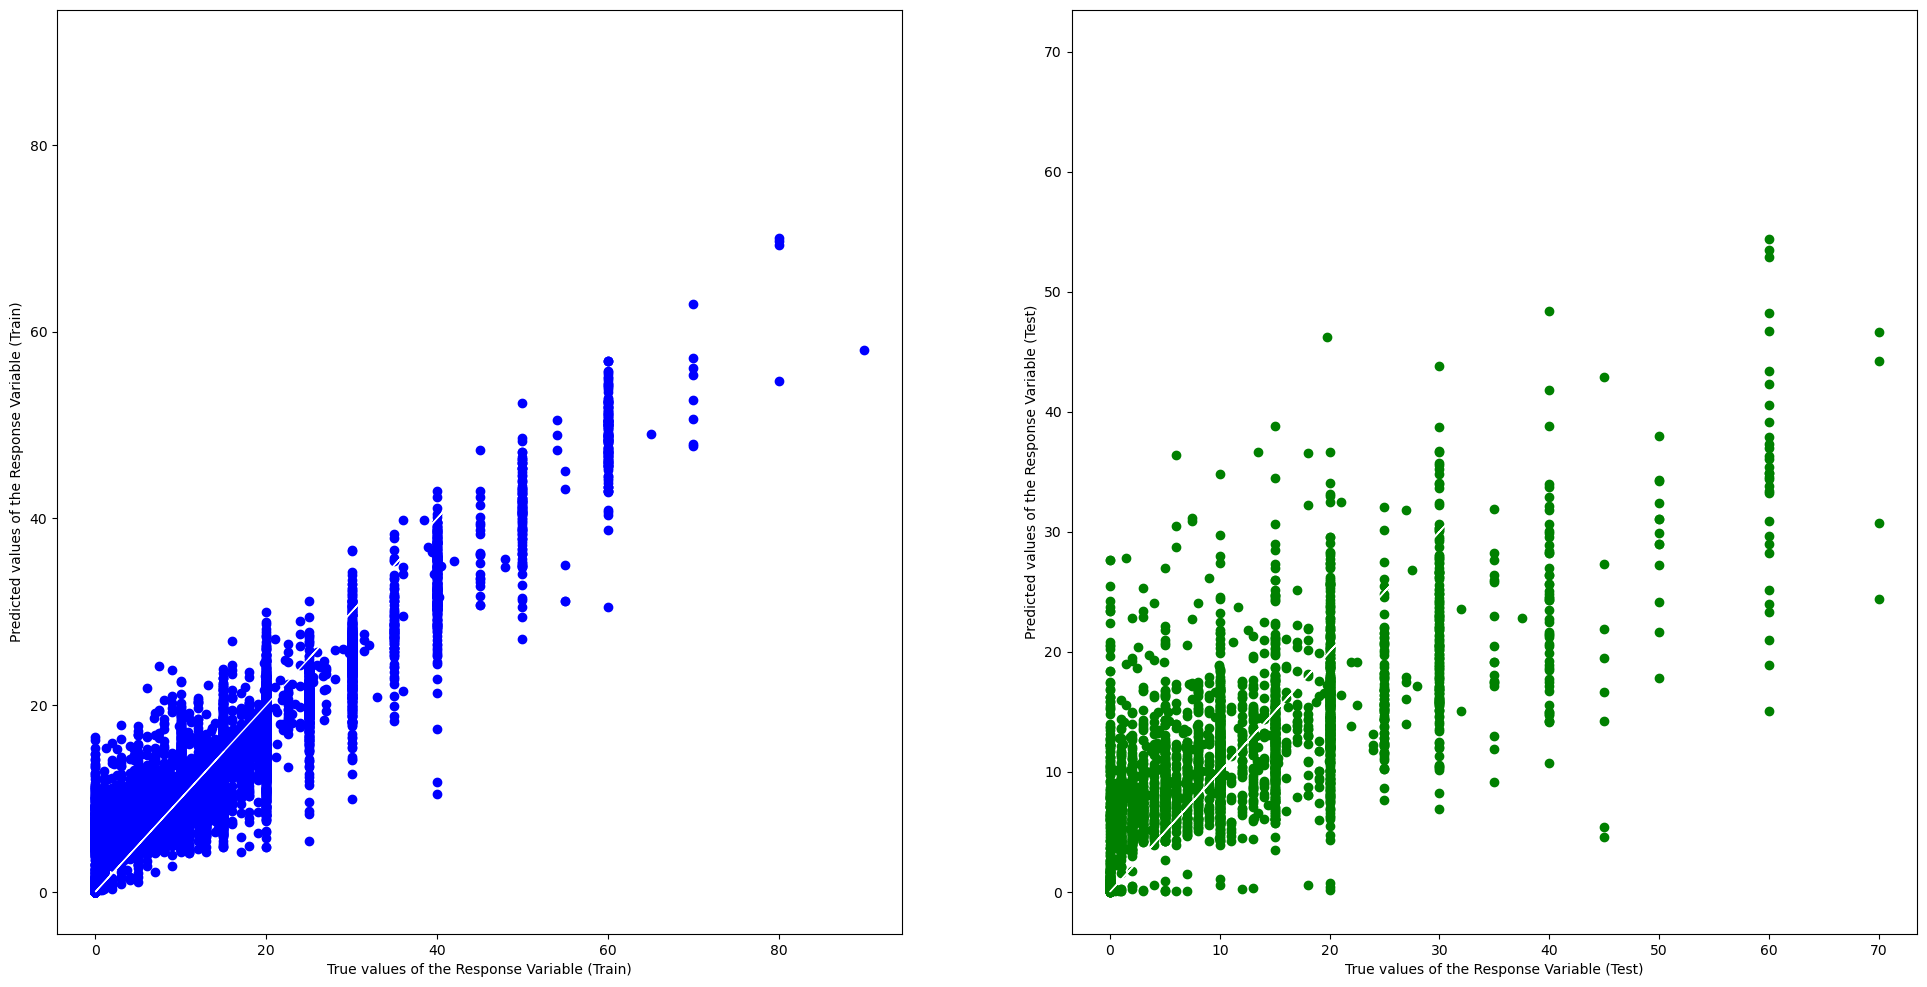

In [80]:
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(Y_train, train_pred, color = "blue")
axes[0].plot(Y_train, Y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(Y_test, test_pred, color = "green")
axes[1].plot(Y_test, Y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [81]:
#adding more variables
audios = pd.read_csv("data/Audio.csv")
audios = pd.DataFrame(audios[["AppID", "Number of full audio languages"]])

lang = pd.read_csv("data/Lang.csv")
lang = pd.DataFrame(lang[["AppID", "Number of languages"]])

round2 = pd.DataFrame(game_data[["AppID", "Metacritic score", "Average playtime two weeks"]]).copy()

round2 = pd.merge(nnew, round2, on="AppID", how='inner')
round2 = pd.merge(audios, round2, on="AppID", how='inner')
round2 = pd.merge(lang, round2, on="AppID", how='inner')

round2.head()


,AppID,Number of languages,Number of full audio languages,Turn-Based Combat,Massively Multiplayer,Multi-player,RPG,Tactical RPG,Exploration,PvP,...,SteamVR Collectibles,Valve Anti-Cheat enabled,Commentary available,Includes Source SDK,Mods (require HL2),Mods,Tracked Controller Support,Price,Metacritic score,Average playtime two weeks
0,1469160,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0
1,320150,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.99,0,0
2,1026420,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.99,62,0
3,485000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0
4,1454010,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.99,0,0


In [82]:
# random forest with round2
test_regr = RandomForestRegressor(max_depth=20, n_estimators=250, max_features=0.4, criterion="squared_error")
# test_regr = RandomForestRegressor(n_estimators=300, max_features=0.3, max_depth=25, criterion='squared_error')

# criterion: absolute error - too slow, poisson - bad, friedman_mse - not bad?, squared_error

Y = round2["Price"]
X = round2.drop(columns=["AppID", "Price"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

test_regr.fit(X_train, Y_train)
train_pred = test_regr.predict(X_train)
test_pred = test_regr.predict(X_test)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = r2_score(Y_train, train_pred)
score2 = r2_score(Y_test, test_pred)
print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))
# 0.5503041673858831

train score:  0.8846319193946128  mse:  14.955927252471911 3.867289393421691
test score:  0.5460983540208173  mse:  61.62690629743657 7.850280650870806


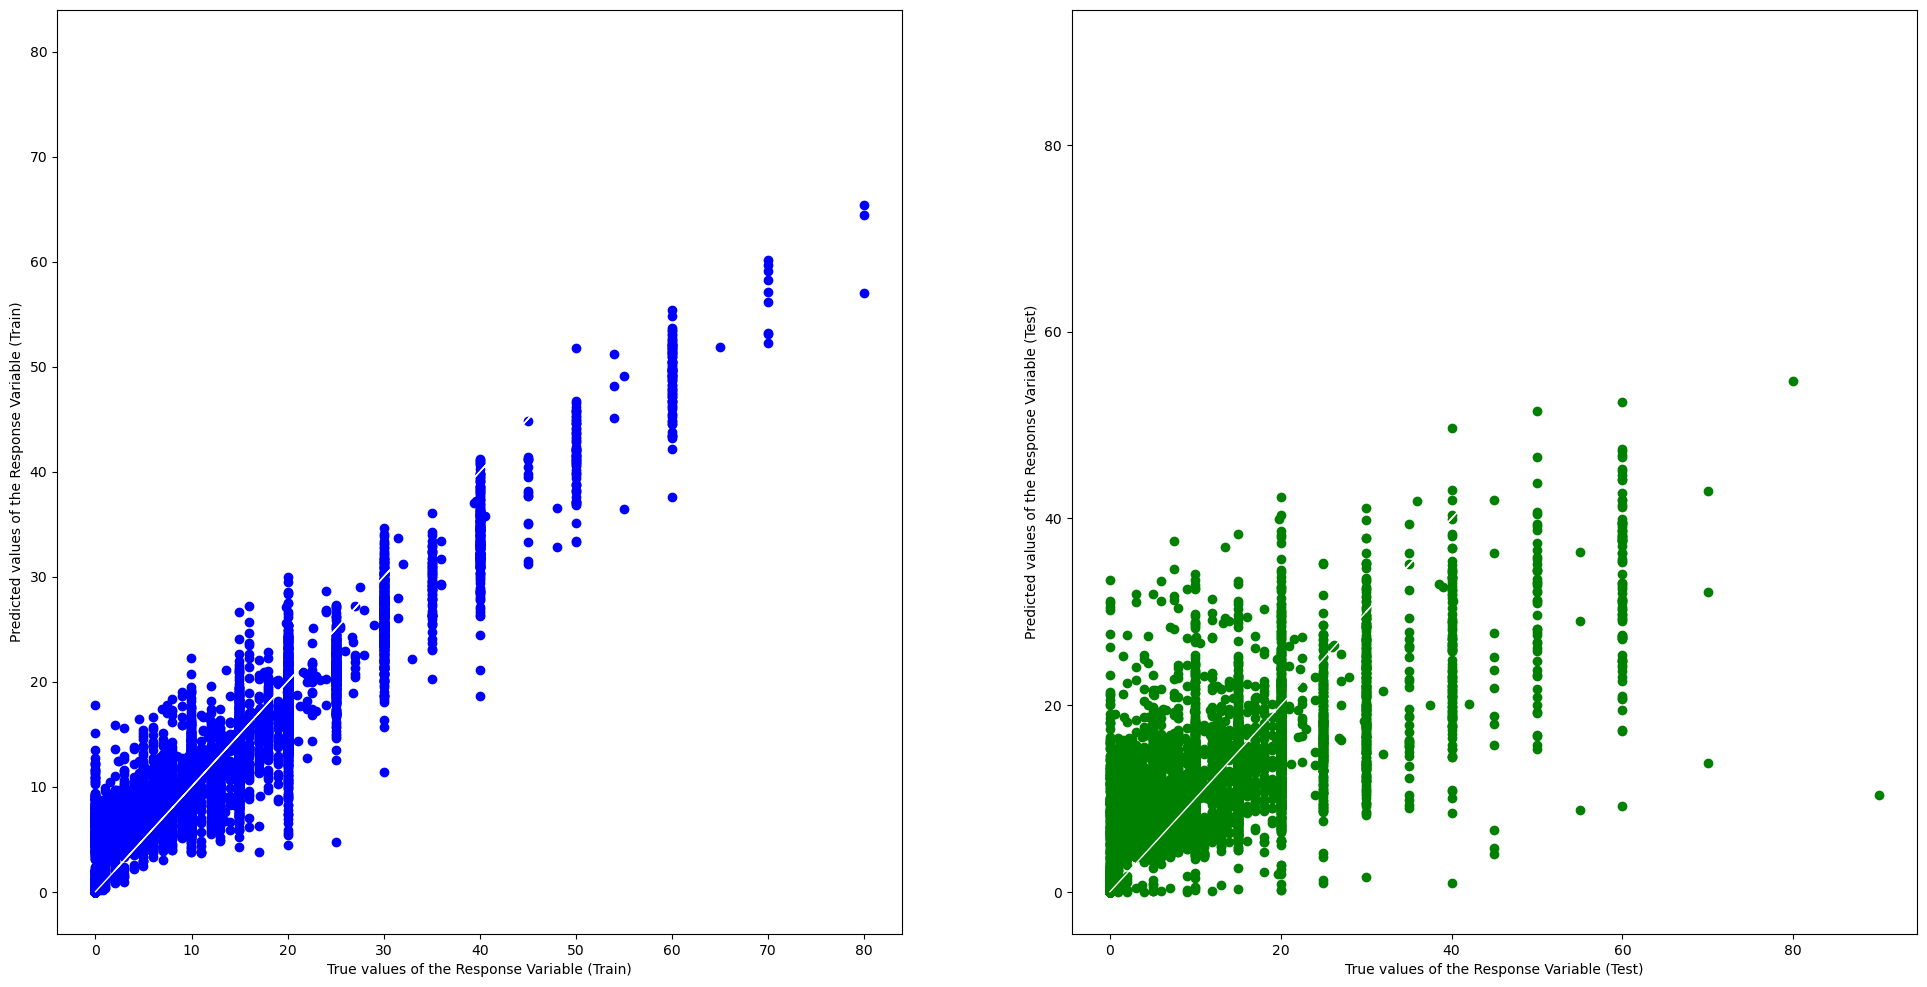

In [83]:
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(Y_train, train_pred, color = "blue")
axes[0].plot(Y_train, Y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(Y_test, test_pred, color = "green")
axes[1].plot(Y_test, Y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [84]:
from sklearn.tree import DecisionTreeRegressor

dreg = DecisionTreeRegressor(max_depth=10, max_features=0.5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
dreg.fit(X_train, Y_train)
train_pred = dreg.predict(X_train)
test_pred = dreg.predict(X_test)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = r2_score(Y_train, train_pred)
score2 = r2_score(Y_test, test_pred)
print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))

train score:  0.5550075230357596  mse:  58.627318995236784 7.656847849816319
test score:  0.3826186407250841  mse:  82.3678862188501 9.075675524105636


In [85]:
from sklearn.neural_network import MLPRegressor
nnreg = MLPRegressor(early_stopping=True)

Y = nnew["Price"]
X = nnew.drop(columns=["AppID", "Price"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

nnreg.fit(X_train.values, Y_train.values)
train_pred = nnreg.predict(X_train.values)
test_pred = nnreg.predict(X_test.values)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = nnreg.score(X_train.values, Y_train.values)
score2 = nnreg.score(X_test.values, Y_test.values)

print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))

# round 2
# train score:  0.651572230368736  mse:  46.29624277097477 6.804134241104799
# test score:  0.47727472652741054  mse:  68.43556216136234 8.272578930500593
# nnew
# train score:  0.7130131002862738  mse:  38.907379071467304 6.237577981193286
# test score:  0.47796096900439244  mse:  66.18420017467507 8.135367242766307

train score:  0.6548590556168586  mse:  46.44353414429422 6.814949313406096
test score:  0.4736915988527204  mse:  67.56985305020035 8.220088384573511


In [86]:
#used while testing potential regression variables, takes very long to run
#reccomend to comment the whole cell out, kept as working

# ["Metacritic score", "Peak CCU", "Recommendations", "Rate_Ratio", "Required age", "Average playtime forever", "Average playtime two weeks", "Full audio languages", "Supported languages", "Windows", "Mac", "Linux"]
arr = ["Metacritic score", "Rate_Ratio", "Average playtime forever", "Average playtime two weeks", "Full audio languages", "Supported languages", "Windows", "Mac", "Linux"]

attempt = ["AppID"]
# nnreg = MLPRegressor(early_stopping=True)
nnreg = RandomForestRegressor(max_depth=20, n_estimators=200, max_features=0.4, criterion="squared_error")

for i in arr:
    attempt.append(i)
    print("\n",i)
    round2 = pd.DataFrame(game_data[attempt]).copy()
    if(i == "Full audio languages"):
        round2 = pd.read_csv("data/Audio.csv")
        round2 = pd.DataFrame(round2[["AppID", "Number of full audio languages"]])
    elif(i == "Supported languages"):
        round2 = pd.read_csv("data/Lang.csv")
        round2 = pd.DataFrame(round2[["AppID", "Number of languages"]])
    elif(i == "Windows"):
        round2["Windows"] = round2["Windows"].astype(int)
    elif(i == "Mac"):
        round2["Mac"] = round2["Mac"].astype(int)
    elif(i == "Linux"):
        round2["Linux"] = round2["Linux"].astype(int)
    
    round2 = pd.merge(nnew, round2, on="AppID", how='inner')

    Y = round2["Price"]
    X = round2.drop(columns=["AppID", "Price"])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

    nnreg.fit(X_train.values, Y_train.values)
    train_pred = nnreg.predict(X_train.values)
    test_pred = nnreg.predict(X_test.values)
    mse = mean_squared_error(Y_train, train_pred)
    mse2 = mean_squared_error(Y_test, test_pred)
    score = nnreg.score(X_train.values, Y_train.values)
    score2 = nnreg.score(X_test.values, Y_test.values)

    print("train score: ",score, " mse: ", mse,  mse**(1/2))
    print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))
    attempt.remove(i)

In [87]:
#Hyperparam tuning
param = {"max_depth": [15, 20, 25], 
         "n_estimators":[100, 150, 200, 250, 300, 350], 
          'max_features': [0.3, 0.4, 0.5],
          'criterion' : ['squared_error', 'friedman_mse']}

Y = round2["Price"]
X = round2.drop(columns=["AppID", "Price"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

rnd_search = RandomizedSearchCV(RandomForestRegressor(), param, n_iter=10, cv=5)
rnd_search.fit(X_train, Y_train)
print(rnd_search.best_params_)
print(rnd_search.best_score_)

{'n_estimators': 300, 'max_features': 0.3, 'max_depth': 25, 'criterion': 'friedman_mse'}
0.5432128052867029


In [88]:
rand_pred = rnd_search.predict(X_test)
mse = mean_squared_error(Y_test, rand_pred)
score = r2_score(Y_test, rand_pred)
print("train score: ",score, " mse: ", mse,  mse**(1/2))

train score:  0.5494314756266016  mse:  59.30946584300862 7.701263912047724


In [89]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(test_regr, X, Y, cv=5)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

# round2 0.49736 accuracy with a standard deviation of 0.02638
# nnew 0.49096 accuracy with a standard deviation of 0.03242

0.54846 accuracy with a standard deviation of 0.01670


---
Adding languages data

In [90]:
# Seperate languages into individual columns
def sep_lang(df, column):
    json_table = []
    json_file = df.to_json(orient='records')
    json_file = json.loads(json_file)

    for j in json_file:
        test = {}
        temp = j[column][1:-1]
        test["AppID"] = j["AppID"]
        test["Name"] = j["Name"]
        test["Price"] = j["Price"]
        
        if temp != "":
            temp = temp.split(",")
            for i in temp:
                i = i.replace("'", '')
                test[i] = 1
        
        json_table.append(test)

    res_table = pd.DataFrame(json_table)
    print(res_table.shape)
    print(res_table.columns.tolist())
    res_table.fillna(value=0, inplace=True)

    print(len(json_table))
    return res_table

In [91]:
uis = pd.DataFrame(game_data[["AppID", "Name", "Price", "Supported languages"]])
vos = pd.DataFrame(game_data[["AppID", "Name", "Price", "Full audio languages"]])

sep_game_ui = sep_lang(uis, "Supported languages")
sep_game_vo = sep_lang(vos, "Full audio languages")

(16081, 70)
['AppID', 'Name', 'Price', 'English', ' Polish', ' French', ' Italian', ' German', ' Spanish - Spain', ' Portuguese', ' Russian', ' Japanese', ' Korean', ' Turkish', ' Czech', ' Portuguese - Brazil', ' Hungarian', ' Dutch', ' Ukrainian', ' Danish', ' Simplified Chinese', ' Traditional Chinese', ' Arabic', ' Spanish - Latin America', 'Simplified Chinese', ' Thai', ' Finnish', ' Norwegian', ' Romanian', ' Swedish', 'Japanese', ' English', ' Greek', ' Vietnamese', ' Bulgarian', 'Portuguese - Brazil', 'Russian', ' German;', 'Traditional Chinese', 'Polish', 'Korean', 'Danish', 'German', 'Spanish - Spain', '#lang_français', 'Czech', 'French', 'Turkish', 'Dutch', 'Bulgarian', 'Thai', 'Arabic', ' Traditional Chinese (text only)', 'Vietnamese', 'English[b][/b]', ' Italian \\r\\n\\r\\n[b][/b] ', 'Romanian', 'English (full audio)', ' Russian\\r\\n[b][/b]', ' German[b][/b]', ' Spanish - Spain\\r\\n[b][/b]', '  Korean', ' Slovakian', 'English\\r\\nRussian\\r\\nSpanish - Spain\\r\\nJapan

In [92]:
# random forest with vo
vo_regr = RandomForestRegressor(max_features=0.4)

Y = sep_game_vo["Price"]
X = sep_game_vo.drop(columns=["AppID", "Price", "Name"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

vo_regr.fit(X_train, Y_train)
train_pred = vo_regr.predict(X_train)
test_pred = vo_regr.predict(X_test)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = r2_score(Y_train, train_pred)
score2 = r2_score(Y_test, test_pred)
print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))

train score:  0.2540988822832907  mse:  97.60045954726927 9.879294486311727
test score:  0.16286225305391244  mse:  112.11597488060592 10.588483124631493


In [93]:
# random forest with ui
ui_regr = RandomForestRegressor(max_features=0.4)

Y = sep_game_ui["Price"]
X = sep_game_ui.drop(columns=["AppID", "Price", "Name"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

ui_regr.fit(X_train, Y_train)
train_pred = ui_regr.predict(X_train)
test_pred = ui_regr.predict(X_test)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = r2_score(Y_train, train_pred)
score2 = r2_score(Y_test, test_pred)
print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))

train score:  0.42124549574001413  mse:  75.9534992901921 8.715130480388236
test score:  0.18566526459550614  mse:  108.61211032207926 10.421713406253277


In [94]:
round3 = pd.merge(round2, sep_game_ui, on=["AppID", "Price"], how="inner")
round3.head()

,AppID,Number of languages,Number of full audio languages,Turn-Based Combat,Massively Multiplayer,Multi-player,RPG,Tactical RPG,Exploration,PvP,...,Spanish - Spain\r\n[b][/b],Korean,Slovakian,English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech,Italian,English Dutch English,Portuguese - Portugal,Indonesian,Hindi,Catalan
0,1469160,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,320150,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1026420,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,485000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1454010,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
#Hyperparam tuning
param = {"max_depth": [15, 20, 25], 
         "n_estimators":[100, 150, 200, 250, 300, 350, 400], 
          'max_features': [0.3, 0.4, 0.5],
          'criterion' : ['squared_error', 'friedman_mse']}

Y = round3["Price"]
X = round3.drop(columns=["AppID", "Price", "Name"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

rnd_search = RandomizedSearchCV(RandomForestRegressor(), param, n_iter=10, cv=5)
rnd_search.fit(X_train, Y_train)
print(rnd_search.best_params_)
print(rnd_search.best_score_)

{'n_estimators': 350, 'max_features': 0.3, 'max_depth': 25, 'criterion': 'squared_error'}
0.5708300536219333


In [ ]:
# Final Regression
# forest_3 = RandomForestRegressor(n_estimators=400, max_features=0.3, max_depth=20, criterion='squared_error')
forest_3 = RandomForestRegressor(n_estimators=250, max_features=0.4, max_depth=25, criterion='friedman_mse')

Y = round3["Price"]
X = round3.drop(columns=["AppID", "Price", "Name"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

forest_3.fit(X_train, Y_train)
train_pred = forest_3.predict(X_train)
test_pred = forest_3.predict(X_test)
mse = mean_squared_error(Y_train, train_pred)
mse2 = mean_squared_error(Y_test, test_pred)
score = r2_score(Y_train, train_pred)
score2 = r2_score(Y_test, test_pred)
print("train score: ",score, " mse: ", mse,  mse**(1/2))
print("test score: ",score2, " mse: ", mse2,  mse2**(1/2))

In [ ]:
scores = cross_val_score(forest_3, X, Y, cv=5)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))
# 0.56333 accuracy with a standard deviation of 0.01540 vo